In [1]:
!pip install rapidfuzz --upgrade

In [2]:
import sys
print(sys.executable)
!{sys.executable} -m pip show rapidfuzz

/Library/Frameworks/Python.framework/Versions/3.11/bin/python3
Name: RapidFuzz
Version: 3.14.3
Summary: rapid fuzzy string matching
Home-page: https://github.com/rapidfuzz/RapidFuzz
Author: 
Author-email: Max Bachmann <pypi@maxbachmann.de>
License-Expression: MIT
Location: /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages
Requires: 
Required-by: 


In [3]:
import sys
print(sys.executable)

/Library/Frameworks/Python.framework/Versions/3.11/bin/python3


In [4]:
! /Library/Frameworks/Python.framework/Versions/3.11/bin/python3 -m pip install rapidfuzz


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip3.11 install --upgrade pip


In [5]:
! /Library/Frameworks/Python.framework/Versions/3.11/bin/python3 -m pip show rapidfuzz

Name: RapidFuzz
Version: 3.14.3
Summary: rapid fuzzy string matching
Home-page: https://github.com/rapidfuzz/RapidFuzz
Author: 
Author-email: Max Bachmann <pypi@maxbachmann.de>
License-Expression: MIT
Location: /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages
Requires: 
Required-by: 


In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
import os
from rapidfuzz import process  # faster replacement for fuzzywuzzy
import matplotlib.pyplot as plt

IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 5  # reduce to 3 if runtime is long
DATA_DIR = "../data/raw/food-101/images"
TRAIN_CSV = "../data/clean/train_cleaned.csv"
TEST_CSV = "../data/clean/test_cleaned.csv"
USDA_PATH = "../data/raw/usda_food_data.csv"

In [24]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

# pick 10 classes to speed up
selected_labels = train_df["label"].value_counts().nlargest(10).index.tolist()
train_df = train_df[train_df["label"].isin(selected_labels)]
test_df = test_df[test_df["label"].isin(selected_labels)]

def get_image_path(img_name):
    return os.path.join(DATA_DIR, img_name + ".jpg")

train_df["image_path"] = train_df["image_name"].apply(get_image_path)
test_df["image_path"] = test_df["image_name"].apply(get_image_path)

In [25]:
import tensorflow as tf

# Image loader
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0
    return img, label

# Convert string labels to integer indices
label_to_index = {name: i for i, name in enumerate(selected_labels)}
index_to_label = {i: name for name, i in label_to_index.items()}

# Create a TensorFlow lookup table
keys_tensor = tf.constant(list(label_to_index.keys()))
vals_tensor = tf.constant(list(label_to_index.values()), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor)
table = tf.lookup.StaticHashTable(table_init, default_value=-1)

# Create datasets 
train_ds = tf.data.Dataset.from_tensor_slices((train_df["image_path"], train_df["label"]))
test_ds = tf.data.Dataset.from_tensor_slices((test_df["image_path"], test_df["label"]))

# Map using the lookup table instead of Python dict
train_ds = train_ds.map(
    lambda x, y: (load_image(x, table.lookup(y))),
    num_parallel_calls=tf.data.AUTOTUNE
)
test_ds = test_ds.map(
    lambda x, y: (load_image(x, table.lookup(y))),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Shuffle, batch, prefetch 
train_ds = train_ds.shuffle(500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [26]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  

model = models.Sequential([
    tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(selected_labels), activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 29s 116ms/step - accuracy: 0.6794 - loss: 1.4256 - val_accuracy: 0.2812 - val_loss: 2.6588
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - accuracy: 0.5295 - loss: 1.5305 - val_accuracy: 0.2536 - val_loss: 2.6018
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 30s 129ms/step - accuracy: 0.6393 - loss: 1.2091 - val_accuracy: 0.2468 - val_loss: 2.8177
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 29s 121ms/step - accuracy: 0.6564 - loss: 1.1282 - val_accuracy: 0.3220 - val_loss: 2.6575
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 29s 122ms/step - accuracy: 0.6597 - loss: 0.9869 - val_accuracy: 0.3440 - val_loss: 2.9806


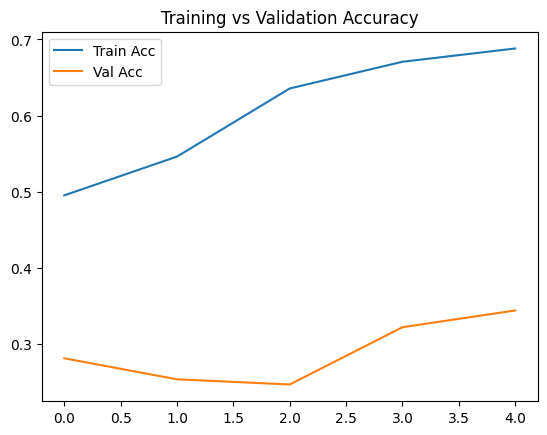

In [27]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS
)
model.save("../data/clean/food101_model.keras")

plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

In [29]:
usda_df = pd.read_csv(USDA_PATH)

def find_closest_food(food_label, usda_df):
    usda_list = usda_df["description"].dropna().tolist()
    match, score, _ = process.extractOne(food_label.replace("_", " "), usda_list)
    if score > 70:
        result = usda_df[usda_df["description"].str.contains(match, case=False, na=False)]
        if not result.empty:
            return result.iloc[0]
    return None

# pick a sample image
sample_path = test_df.iloc[0]["image_path"]
img = tf.expand_dims(load_image(sample_path, "dummy")[0], 0)
pred = model.predict(img)
pred_label = index_to_label[np.argmax(pred)]

print("Predicted Food:", pred_label)
info = find_closest_food(pred_label, usda_df)
if info is not None:
    print("\nNutrition Info:")
    print(info[["description", "calories", "protein","fat","carbohydrates"]])
else:
    print("No match found in USDA database.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Food: churros

Nutrition Info:
description      Churros
calories           419.0
protein             6.05
fat                22.21
carbohydrates      48.87
Name: 67, dtype: object
